<a href="https://colab.research.google.com/github/Evelynrodrigues28/Challenge-TelecomX/blob/main/TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Extração de dados

* Carregar os dados diretamente da API utilizando Python

* Converter os dados para um DataFrame do Pandas para facilitar a manipulação

---

In [2]:
import pandas as pd
import requests

url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'

response = requests.get(url)

if response.status_code == 200:
    dados = response.json()
    df = pd.DataFrame(dados)
    print("\n Visualização inicial dos dados:")
    print(df.head())
else:
    print(f" Erro ao carregar os dados. Código: {response.status_code}")



 Visualização inicial dos dados:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fibe

2.

# 2. Visualiação dos dados

* Extrai as colunas simples

* Separa os dados em Data Frames individuais com prefixos

* Junta tudo em um DataFrame único

---

In [3]:

customer_df = pd.DataFrame([item['customer'] for item in dados]).add_prefix('customer_')
phone_df = pd.DataFrame([item['phone'] for item in dados]).add_prefix('phone_')
internet_df = pd.DataFrame([item['internet'] for item in dados]).add_prefix('internet_')
account_df = pd.DataFrame([item['account'] for item in dados]).add_prefix('account_')

charges_df = pd.json_normalize(account_df['account_Charges'])
charges_df.rename(columns=lambda x: f'account_Charges.{x}', inplace=True)

account_df = account_df.drop(columns=['account_Charges']).join(charges_df)

tamanhos = [len(df) for df in [customer_df, phone_df, internet_df, account_df]]
if not all(tamanho == len(dados) for tamanho in tamanhos):
    raise ValueError("Os DataFrames extraídos têm tamanhos diferentes!")

dados_tratados = pd.concat([
    pd.DataFrame({
        'customerID': [item['customerID'] for item in dados],
        'Churn': [item['Churn'] for item in dados]
    }),
    customer_df, phone_df, internet_df, account_df
], axis=1)

print(f"Visualização após o Tratamento: {dados_tratados.shape}")
print("\nPrimeiras linhas do DataFrame tratado:")
print(dados_tratados.head())



Visualização após o Tratamento: (7267, 21)

Primeiras linhas do DataFrame tratado:
   customerID Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No          

# 3. Tratamento de dados

* Verifica valores nulos
* Identifica registros duplicados
* Converte a coluna account_Charges.Total para tipo numérico
* Calcula a média e substitui os valores da coluna account_Charges.Total

---

In [4]:
print(" Valores nulos por coluna:")
print(dados_tratados.isnull().sum())

print("\n Total de linhas com pelo menos um valor nulo:")
print(dados_tratados.isnull().any(axis=1).sum())

duplicados = dados_tratados[dados_tratados.duplicated(subset='customerID', keep=False)]

print(f" Total de registros duplicados com base em 'customerID': {duplicados.shape[0]}")

if not duplicados.empty:
    print("\n📋 Registros duplicados:")
    print(duplicados)

dados_tratados['account_Charges.Total'] = pd.to_numeric(
    dados_tratados['account_Charges.Total'], errors='coerce'
)
print(" Total de valores não convertidos:", dados_tratados['account_Charges.Total'].isnull().sum())

print(dados_tratados.isnull().sum())

media_total = dados_tratados['account_Charges.Total'].mean()
dados_tratados['account_Charges.Total'] = dados_tratados['account_Charges.Total'].fillna(media_total)

print("\n Valores nulos após preenchimento:")
print(dados_tratados.isnull().sum())








 Valores nulos por coluna:
customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Dependents          0
customer_tenure              0
phone_PhoneService           0
phone_MultipleLines          0
internet_InternetService     0
internet_OnlineSecurity      0
internet_OnlineBackup        0
internet_DeviceProtection    0
internet_TechSupport         0
internet_StreamingTV         0
internet_StreamingMovies     0
account_Contract             0
account_PaperlessBilling     0
account_PaymentMethod        0
account_Charges.Monthly      0
account_Charges.Total        0
dtype: int64

 Total de linhas com pelo menos um valor nulo:
0
 Total de registros duplicados com base em 'customerID': 0
 Total de valores não convertidos: 11
customerID                    0
Churn                         0
customer_gender               0
customer_SeniorCitizen        0
customer_Partner              0
cu

In [5]:
print("Valores únicos em 'Churn':", dados_tratados['Churn'].unique())

num_nulos = dados_tratados['Churn'].isnull().sum()
num_vazios = (dados_tratados['Churn'] == '').sum()

print(f"Valores nulos ou vazios em 'Churn': {num_nulos} nulos, {num_vazios} vazios")

valor_mais_frequente = dados_tratados['Churn'].mode()[0] if not dados_tratados['Churn'].empty else 'No'

if num_nulos > 0 or num_vazios > 0:
    dados_tratados['Churn'] = dados_tratados['Churn'].replace('', valor_mais_frequente).fillna(valor_mais_frequente)
    print(f"Valores nulos ou vazios em 'Churn' após tratamento: {valor_mais_frequente}")





Valores únicos em 'Churn': ['No' 'Yes' '']
Valores nulos ou vazios em 'Churn': 0 nulos, 224 vazios
Valores nulos ou vazios em 'Churn' após tratamento: No


In [6]:
dados_tratados['Contas_Diarias'] = dados_tratados['account_Charges.Total'] / (dados_tratados['customer_tenure'] * 30)

print(dados_tratados[['account_Charges.Total', 'customer_tenure', 'Contas_Diarias']].head())



   account_Charges.Total  customer_tenure  Contas_Diarias
0                 593.30                9        2.197407
1                 542.40                9        2.008889
2                 280.85                4        2.340417
3                1237.85               13        3.173974
4                 267.40                3        2.971111


In [7]:
print(" Verificação final dos dados limpos:")

print("\nValores nulos por coluna:")
print(dados_tratados.isnull().sum())

duplicados = dados_tratados[dados_tratados.duplicated(subset='customerID', keep=False)]

 Verificação final dos dados limpos:

Valores nulos por coluna:
customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Dependents          0
customer_tenure              0
phone_PhoneService           0
phone_MultipleLines          0
internet_InternetService     0
internet_OnlineSecurity      0
internet_OnlineBackup        0
internet_DeviceProtection    0
internet_TechSupport         0
internet_StreamingTV         0
internet_StreamingMovies     0
account_Contract             0
account_PaperlessBilling     0
account_PaymentMethod        0
account_Charges.Monthly      0
account_Charges.Total        0
Contas_Diarias               0
dtype: int64


# 4. Padronização e Transformação de Dados

* Verifica as colunas binárias que devem ser convertidas de texto para números

* Converte as colunas binárias

* Substitui valores inesperados como 'No phone service' e 'No internet service' por 'No' para padronizar os dados.

* Garante que a coluna que indica se o cliente é idoso (SeniorCitizen) esteja no formato inteiro

* Ajusta automaticamente a lista de colunas a tratar

---

In [8]:

colunas_binarias = [
    'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines',
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies',
    'account_PaperlessBilling', 'Churn'
]

print("\n Valores  nas colunas binárias:")
for coluna in colunas_binarias:
    valores = dados_tratados[coluna].unique()
    print(f" - {coluna}: {valores}")




 Valores  nas colunas binárias:
 - customer_Partner: ['Yes' 'No']
 - customer_Dependents: ['Yes' 'No']
 - phone_PhoneService: ['Yes' 'No']
 - phone_MultipleLines: ['No' 'Yes' 'No phone service']
 - internet_OnlineSecurity: ['No' 'Yes' 'No internet service']
 - internet_OnlineBackup: ['Yes' 'No' 'No internet service']
 - internet_DeviceProtection: ['No' 'Yes' 'No internet service']
 - internet_TechSupport: ['Yes' 'No' 'No internet service']
 - internet_StreamingTV: ['Yes' 'No' 'No internet service']
 - internet_StreamingMovies: ['No' 'Yes' 'No internet service']
 - account_PaperlessBilling: ['Yes' 'No']
 - Churn: ['No' 'Yes']


In [9]:
dados_tratados = dados_tratados.copy()

valores_inesperados = ['No phone service', 'No internet service']
dados_tratados.replace(valores_inesperados, 'No', inplace=True)

colunas_binarias = [
    'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines',
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies',
    'account_PaperlessBilling', 'Churn'
]

for coluna in colunas_binarias:
    dados_tratados[coluna] = dados_tratados[coluna].map({'Yes': 1, 'No': 0})

dados_tratados['customer_SeniorCitizen'] = dados_tratados['customer_SeniorCitizen'].astype(int)

novo_nome_colunas = {
 'customer_gender': 'Genero',
    'customer_SeniorCitizen': 'Idoso',
    'customer_Partner': 'Parceiro',
    'customer_Dependents': 'Dependentes',
    'customer_tenure': 'Meses_Contrato',
    'phone_PhoneService': 'Servico_Telefone',
    'phone_MultipleLines': 'Multiplas_Linhas',
    'internet_InternetService': 'Servico_Internet',
    'internet_OnlineSecurity': 'Seguranca_Online',
    'internet_OnlineBackup': 'Backup_Online',
    'internet_DeviceProtection': 'Protecao_Dispositivo',
    'internet_TechSupport': 'Suporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Filmes',
    'account_Contract': 'Tipo_Contrato',
    'account_PaperlessBilling': 'Fatura_Online',
    'account_PaymentMethod': 'Metodo_Pagamento',
    'account_Charges.Monthly': 'Fatura_Mensal',
    'account_Charges.Total': 'Gasto_Total',
    'Churn': 'Evasao'
}

dados_tratados.rename(columns=novo_nome_colunas, inplace=True)

print("Visualização das primeiras linhas após transformação:")
print(dados_tratados.head())

print("\nResumo das colunas após transformação:")
print(dados_tratados.info())






Visualização das primeiras linhas após transformação:
   customerID  Evasao  Genero  Idoso  Parceiro  Dependentes  Meses_Contrato  \
0  0002-ORFBO       0  Female      0         1            1               9   
1  0003-MKNFE       0    Male      0         0            0               9   
2  0004-TLHLJ       1    Male      0         0            0               4   
3  0011-IGKFF       1    Male      1         1            0              13   
4  0013-EXCHZ       1  Female      1         1            0               3   

   Servico_Telefone  Multiplas_Linhas Servico_Internet  ...  \
0                 1                 0              DSL  ...   
1                 1                 1              DSL  ...   
2                 1                 0      Fiber optic  ...   
3                 1                 0      Fiber optic  ...   
4                 1                 0      Fiber optic  ...   

   Protecao_Dispositivo  Suporte_Tecnico  Streaming_TV  Streaming_Filmes  \
0               

#5. Analise Descritiva

* Calculo da média, desvio de padrão, minimo e máximo

In [10]:

colunas_numericas = dados_tratados.select_dtypes(include=['number']).columns

print("Estatísticas descritivas (média, desvio padrão, mínimo, máximo, contagem):")
print(dados_tratados[colunas_numericas].describe())

medianas = dados_tratados[colunas_numericas].median()
print("\nMediana para colunas numéricas:")
print(medianas)



Estatísticas descritivas (média, desvio padrão, mínimo, máximo, contagem):
            Evasao        Idoso     Parceiro  Dependentes  Meses_Contrato  \
count  7267.000000  7267.000000  7267.000000  7267.000000     7267.000000   
mean      0.257190     0.162653     0.484106     0.300124       32.346498   
std       0.437115     0.369074     0.499782     0.458343       24.571773   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.000000     0.000000     0.000000     0.000000        9.000000   
50%       0.000000     0.000000     0.000000     0.000000       29.000000   
75%       1.000000     0.000000     1.000000     1.000000       55.000000   
max       1.000000     1.000000     1.000000     1.000000       72.000000   

       Servico_Telefone  Multiplas_Linhas  Seguranca_Online  Backup_Online  \
count       7267.000000       7267.000000       7267.000000    7267.000000   
mean           0.902711          0.421770          0.285950       0.344571 

# 6. Distribuição da Evasao

* Visualiação da proporção de Evasao de clientes





---

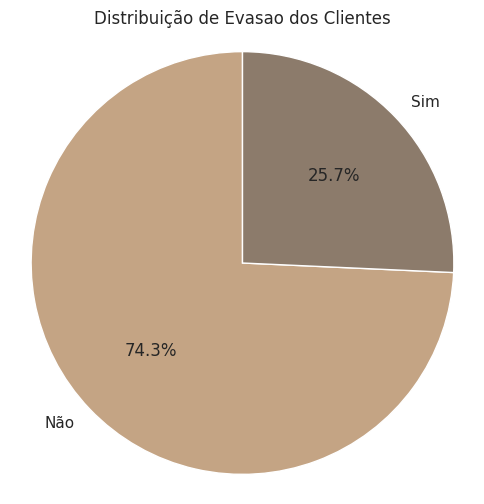

In [11]:
import matplotlib.pyplot as plt

contagem_churn = dados_tratados['Evasao'].value_counts()

contagem_churn.index = contagem_churn.index.map({1: 'Sim', 0: 'Não'})

cores = ['#C4A484', '#8C7B6B']

plt.figure(figsize=(6,6))
plt.pie(contagem_churn, labels=contagem_churn.index, autopct='%1.1f%%', startangle=90, colors=cores)
plt.title('Distribuição de Evasao dos Clientes')
plt.axis('equal')
plt.show()



#7. Evasão por Variáveis Categóricas

* Visualização da distribuição por variáveis categóricas

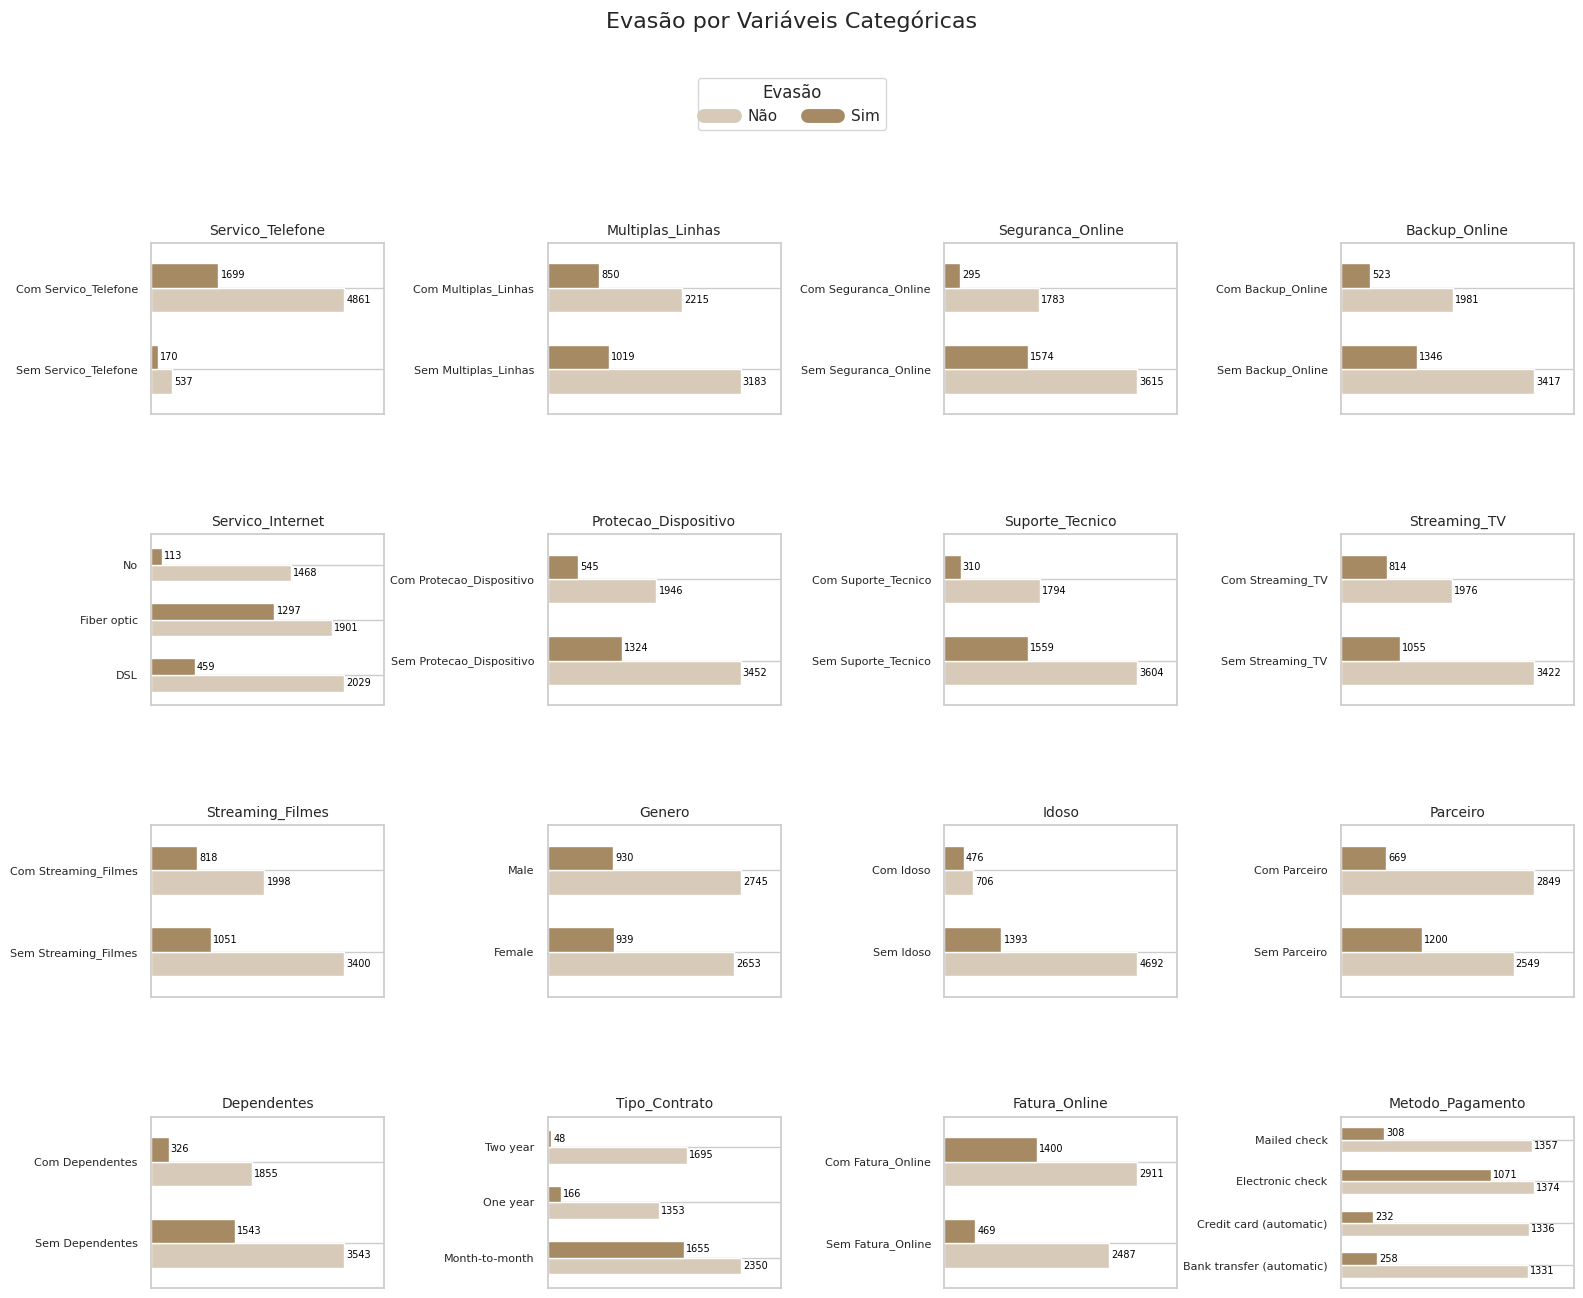

In [12]:
import matplotlib.pyplot as plt
import math


Variaveis_categoricas = [
    'Servico_Telefone', 'Multiplas_Linhas', 'Seguranca_Online', 'Backup_Online','Servico_Internet',
    'Protecao_Dispositivo', 'Suporte_Tecnico', 'Streaming_TV', 'Streaming_Filmes','Genero', 'Idoso',
    'Parceiro', 'Dependentes', 'Tipo_Contrato', 'Fatura_Online', 'Metodo_Pagamento'
]

for servico in Variaveis_categoricas:
    dados_tratados[servico] = dados_tratados[servico].replace('No internet service', 0)

dados_plot = dados_tratados.copy()
dados_plot['Evasao'] = dados_plot['Evasao'].replace({0: 'Não', 1: 'Sim'})

cores_bege = {'Não': '#D8CAB8', 'Sim': '#A68A64'}

n = len(Variaveis_categoricas)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, servico in enumerate(Variaveis_categoricas):
    ax = axes[i]

    contagem = pd.crosstab(dados_plot[servico], dados_plot['Evasao'])

    for status in ['Não', 'Sim']:
        if status not in contagem.columns:
            contagem[status] = 0

    contagem = contagem[['Não', 'Sim']]
    contagem.plot(kind='barh', stacked=False, color=[cores_bege['Não'], cores_bege['Sim']], ax=ax, width=0.6, legend=False)

    categorias = contagem.index.tolist()
    if set(categorias) == {0, 1}:
        ax.set_yticklabels([f'Sem {servico}', f'Com {servico}'])
    else:
        ax.set_yticklabels(categorias)

    ax.set_title(f'{servico}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    xmax = ax.get_xlim()[1]
    ax.set_xlim(0, xmax * 1.15)

    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            label = f'{int(width)}'
            ax.annotate(label, (width + xmax * 0.01, y), va='center', ha='left', fontsize=7, color='black')

handles = [
    plt.Line2D([0], [0], color=cores_bege['Não'], lw=10, label='Não'),
    plt.Line2D([0], [0], color=cores_bege['Sim'], lw=10, label='Sim')
]
fig.legend(
    handles=handles,
    title='Evasão',
    title_fontsize=12,
    fontsize=11,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=2
)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Evasão por Variáveis Categóricas', y=1.08, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.show()
















#8. Evasao por variáveis Numéricas
* Visualização da distribuição por variáveis numéricas

In [13]:
import numpy as np
import pandas as pd

variaveis = ['Gasto_Total', 'Meses_Contrato', 'Fatura_Mensal', 'Contas_Diarias']
num_bins = 5

dados_tratados[variaveis] = dados_tratados[variaveis].replace([np.inf, -np.inf], np.nan)

for var in variaveis:
    mediana = dados_tratados[var].median()
    dados_tratados[var] = dados_tratados[var].fillna(mediana)

for var in variaveis:
    dados_tratados[f'{var}_Faixa'] = pd.cut(dados_tratados[var], bins=num_bins)

    resumo = pd.crosstab(
        dados_tratados[f'{var}_Faixa'],
        dados_tratados['Evasao'],
        rownames=[f'Faixa de {var}'],
        colnames=['Evasao']
    )

    resumo.columns = ['Nao', 'Sim']

    print(f'\nResumo de evasão por faixas da variável {var}:')
    print(resumo)






Resumo de evasão por faixas da variável Gasto_Total:
                       Nao   Sim
Faixa de Gasto_Total            
(10.134, 1752.0]      2774  1295
(1752.0, 3485.2]       934   291
(3485.2, 5218.4]       748   142
(5218.4, 6951.6]       622   104
(6951.6, 8684.8]       320    37

Resumo de evasão por faixas da variável Meses_Contrato:
                          Nao   Sim
Faixa de Meses_Contrato            
(-0.072, 14.4]           1360  1099
(14.4, 28.8]              853   295
(28.8, 43.2]              806   215
(43.2, 57.6]              837   142
(57.6, 72.0]             1542   118

Resumo de evasão por faixas da variável Fatura_Mensal:
                         Nao  Sim
Faixa de Fatura_Mensal           
(18.15, 38.35]          1656  205
(38.35, 58.45]           768  271
(58.45, 78.55]          1003  403
(78.55, 98.65]          1201  675
(98.65, 118.75]          770  315

Resumo de evasão por faixas da variável Contas_Diarias:
                          Nao  Sim
Faixa de Contas_Diar

In [14]:
variaveis = ['Meses_Contrato', 'Fatura_Mensal', 'Gasto_Total', 'Contas_Diarias']

for var in variaveis:
    nulos_var = dados_tratados[var].isnull().sum()
    nulos_evasao = dados_tratados['Evasao'].isnull().sum()
    minimo = dados_tratados[var].min()
    maximo = dados_tratados[var].max()

    print(f"Valores nulos em {var}: {nulos_var}")
    print(f"Valores nulos em Evasao: {nulos_evasao}")
    print(f"Intervalo de {var}: {minimo} a {maximo}\n")


Valores nulos em Meses_Contrato: 0
Valores nulos em Evasao: 0
Intervalo de Meses_Contrato: 0 a 72

Valores nulos em Fatura_Mensal: 0
Valores nulos em Evasao: 0
Intervalo de Fatura_Mensal: 18.25 a 118.75

Valores nulos em Gasto_Total: 0
Valores nulos em Evasao: 0
Intervalo de Gasto_Total: 18.8 a 8684.8

Valores nulos em Contas_Diarias: 0
Valores nulos em Evasao: 0
Intervalo de Contas_Diarias: 0.45916666666666667 a 4.046666666666667



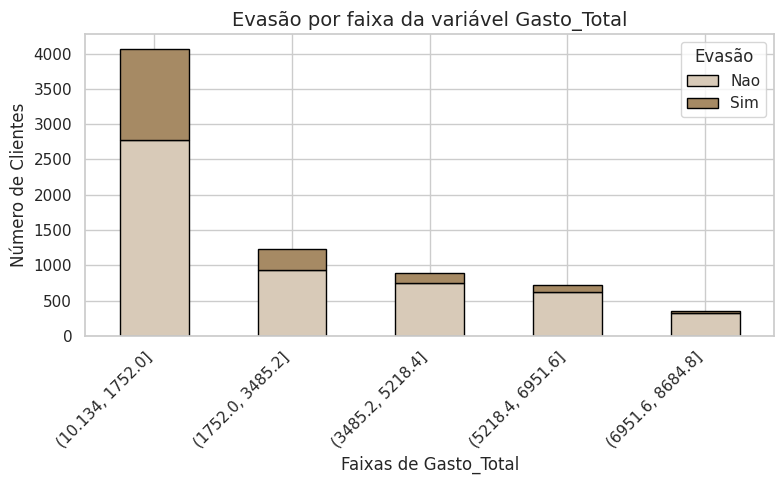

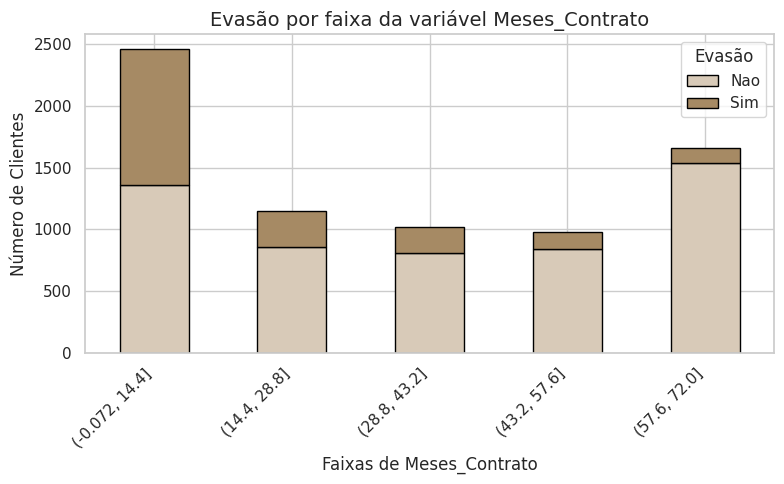

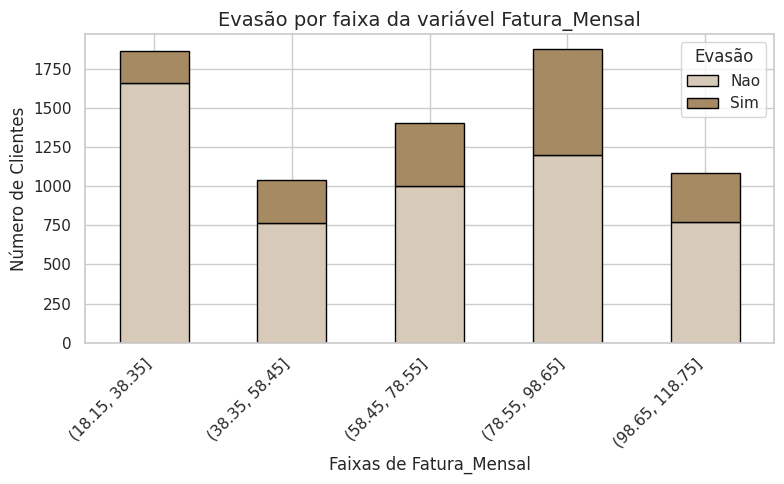

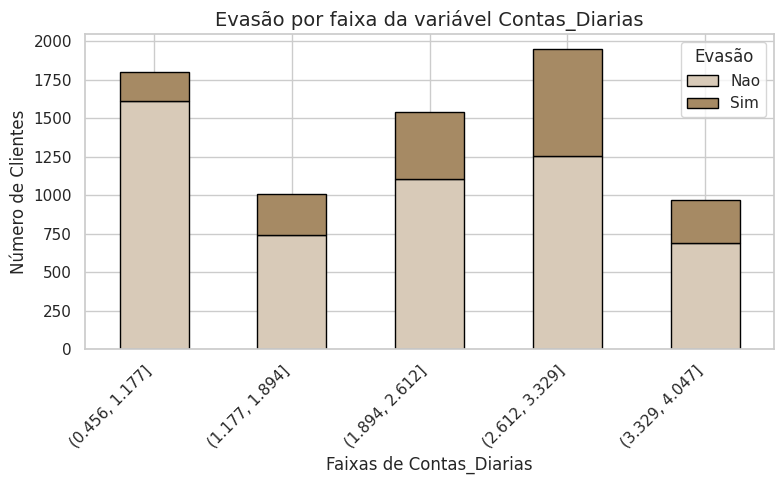

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lista de variáveis numéricas e cores personalizadas
variaveis = ['Gasto_Total', 'Meses_Contrato', 'Fatura_Mensal', 'Contas_Diarias']
cores_personalizadas = {'Nao': '#D8CAB8', 'Sim': '#A68A64'}

# Corrige valores ausentes e infinitos
for var in variaveis:
    dados_tratados[var] = dados_tratados[var].replace([np.inf, -np.inf], np.nan)
    dados_tratados[var] = dados_tratados[var].fillna(dados_tratados[var].median())

    # Cria faixas para a variável
    dados_tratados[f'{var}_Faixa'] = pd.cut(dados_tratados[var], bins=5)

# Padroniza valores da coluna Evasao (caso necessário)
dados_tratados['Evasao'] = dados_tratados['Evasao'].replace({
    1: 'Sim', 0: 'Nao',
    'Yes': 'Sim', 'No': 'Nao',
    True: 'Sim', False: 'Nao',
    'Não': 'Nao'
})

# Gera os gráficos
for var in variaveis:
    faixa = f'{var}_Faixa'
    resumo = pd.crosstab(dados_tratados[faixa], dados_tratados['Evasao'])

    # Garante que ambas colunas existam
    for col in ['Nao', 'Sim']:
        if col not in resumo.columns:
            resumo[col] = 0
    resumo = resumo[['Nao', 'Sim']]  # ordena colunas

    # Plota o gráfico
    resumo.plot(
        kind='bar',
        stacked=True,
        figsize=(8, 5),
        color=[cores_personalizadas['Nao'], cores_personalizadas['Sim']],
        edgecolor='black'
    )

    plt.title(f'Evasão por faixa da variável {var}', fontsize=14)
    plt.xlabel(f'Faixas de {var}')
    plt.ylabel('Número de Clientes')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Evasão')
    plt.tight_layout()
    plt.show()




